# ASOS Digital Experiments Datasets - Experiments

This notebook contains the code required to reproduce the experiments using the ASOS Digital Experiments Dataset, as described in Section 5 of the paper Datasets for Online Controlled Experiments.

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set_theme(style="ticks", palette=sns.color_palette("Set2"))

In [2]:
# Specifying the directories and paths
working_folder = "."

figures_folder = working_folder + os.path.sep + 'figures' + os.path.sep
if not os.path.isdir(figures_folder):
    os.mkdir(figures_folder)

data_folder = working_folder + os.path.sep + 'data' + os.path.sep

if not os.path.isdir(data_folder):
    os.mkdir(data_folder)

abtest_metrics_local_path = data_folder + 'asos_digital_experiments_dataset.parquet'
abtest_metrics_remote_path = "https://osf.io/62t7f/download"

# Download the dataset if it does not already exist
# The body of the if-statement is a shell command
if not os.path.exists(abtest_metrics_local_path):
    !wget -O $abtest_metrics_local_path $abtest_metrics_remote_path

# Load the dataset
abtest_metrics_df = pd.read_parquet(abtest_metrics_local_path)

--2024-10-25 15:45:48--  https://osf.io/62t7f/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.de-1.osf.io/v1/resources/64jsb/providers/osfstorage/61295e4138595801222ebfde?action=download&direct&version=1 [following]
--2024-10-25 15:45:48--  https://files.de-1.osf.io/v1/resources/64jsb/providers/osfstorage/61295e4138595801222ebfde?action=download&direct&version=1
Resolving files.de-1.osf.io (files.de-1.osf.io)... 35.186.249.111
Connecting to files.de-1.osf.io (files.de-1.osf.io)|35.186.249.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003239 (980K) [application/octet-stream]
Saving to: ‘./data/asos_digital_experiments_dataset.parquet’

./data/asos_digital 100%[===================>] 979.73K  1.30MB/s    in 0.7s    

2024-10-25 15:45:50 (1.30 MB/s) - ‘./data/asos_digital_experiments_dataset.parquet’ saved [1003239/100

## Parameters

In [3]:
alpha = 0.05

## Function definitions

In [4]:
def unnormalized_effect_size(mean_x: float, mean_y: float):
    return (mean_y - mean_x)

def cohens_d(
    mean_x: float, mean_y: float, variance_x: float,
    variance_y: float, count_x: float, count_y: float):
    return (
        (mean_y - mean_x) /
        np.sqrt(((count_x - 1) * variance_x + (count_y - 1) * variance_y) /
                (count_x + count_y - 2))
    )

def bayesian_effect_size(
    mean_x: float, mean_y: float, variance_x: float,
    variance_y: float, count_x: float, count_y: float):

    return(
        (mean_y - mean_x) /
        np.sqrt((variance_x / count_x + variance_y / count_y) /
                (1.0 / count_x + 1.0 / count_y))
    )

In [5]:
def mSPRT_vanilla_normal_p_value_aux(
    mean_x: float, mean_y: float, variance_x: float,
    variance_y: float, count_x: float, count_y: float,
    theta_0: float = 0, tau_sq: float = 0.0001):

    if (count_x == 0) or (count_y == 0):
        return 1.0

    count_mean = 2 / (1/count_x + 1/count_y)

    test_statistic = (
      np.sqrt((variance_x + variance_y)/
              (variance_x + variance_y + count_mean * tau_sq)) *
      np.exp((count_mean ** 2.0 * tau_sq *
              (mean_y - mean_x - theta_0) ** 2.0) /
             (2.0 * (variance_x + variance_y) *
              (variance_x + variance_y + count_mean * tau_sq)))
    )
    return 1.0 / max(1.0, test_statistic)


In [6]:
def bayes_factor(
    mean_x: float, mean_y: float, variance_x: float,
    variance_y: float, count_x: float, count_y: float,
    theta_0: float = 0, V_sq: float = 0.0001):

    if (count_x == 0) or (count_y == 0):
        return 1.0

    effect_size = (
        bayesian_effect_size(
            mean_x=mean_x, mean_y=mean_y, variance_x=variance_x,
            variance_y=variance_y, count_x=count_x, count_y=count_y))

    effective_sample_size_inverse = 1.0 / count_x + 1.0 / count_y

    # Return the Bayes factor, which is the likelihood of
    # the calculated effect size under H_1 over that of H_0
    return (
        norm.pdf(effect_size, theta_0,
                 np.sqrt(V_sq + effective_sample_size_inverse)) /
        norm.pdf(effect_size, theta_0,
                 np.sqrt(effective_sample_size_inverse))
    )

def bayesian_posterior_H0_probability(
    mean_x: float, mean_y: float, variance_x: float,
    variance_y: float, count_x: float, count_y: float,
    theta_0: float = 0, V_sq: float = 0.0001,
    prior_H0_probability: float = 0.75):

    prior_odds = (1.0 - prior_H0_probability) / prior_H0_probability
    bf = bayes_factor(mean_x=mean_x, mean_y=mean_y,
                      variance_x=variance_x, variance_y=variance_y,
                      count_x=count_x, count_y=count_y,
                      theta_0=theta_0, V_sq=V_sq)

    posterior_odds = bf * prior_odds

    return(1 / (posterior_odds + 1))


## Dataset descriptive statistics

In [7]:
print(f"Experiment count: {len(abtest_metrics_df['experiment_id'].unique())}")

print(f"Total treatment count: {len(abtest_metrics_df[['experiment_id', 'variant_id']].drop_duplicates())}")

Experiment count: 78
Total treatment count: 99


In [8]:
# Get the joint keys for rows that corresponds to the
# final record of the experiment
experiment_keys_overall_df = \
abtest_metrics_df \
.groupby(['experiment_id', 'variant_id', 'metric_id'])\
.agg({'time_since_start':'max'})

In [9]:
effect_size_df = (
  experiment_keys_overall_df
  .reset_index()
  .merge(abtest_metrics_df, how='inner')
)

effect_size_df['unnormalized_effect_size'] = (
  effect_size_df.apply(
    lambda row: unnormalized_effect_size(
      mean_x=row['mean_c'], mean_y=row['mean_t']),
    axis=1)
)

effect_size_df['cohens_d'] = (
  effect_size_df.apply(
    lambda row: cohens_d(
      mean_x=row['mean_c'], mean_y=row['mean_t'],
      variance_x=row['variance_c'], variance_y=row['variance_t'],
      count_x=row['count_c'], count_y=row['count_t']),
    axis=1)
)

effect_size_df['bayesian_effect_size'] = (
  effect_size_df.apply(
    lambda row: bayesian_effect_size(
      mean_x=row['mean_c'], mean_y=row['mean_t'],
      variance_x=row['variance_c'], variance_y=row['variance_t'],
      count_x=row['count_c'], count_y=row['count_t']),
    axis=1)
)

In [10]:
effect_size_df

,experiment_id,variant_id,metric_id,time_since_start,count_c,count_t,mean_c,mean_t,variance_c,variance_t,unnormalized_effect_size,cohens_d,bayesian_effect_size
0,036afc,2,1,76.5,1050994.0,1050508.0,0.586768,0.587275,0.242471,0.242383,0.000507,0.001029,0.001029
1,036afc,2,2,76.5,1050994.0,1050508.0,2.123119,2.116594,11.830135,11.710985,-0.006525,-0.001902,-0.001902
2,036afc,2,3,76.5,1050994.0,1050508.0,5.966040,5.959434,109.673591,109.676649,-0.006606,-0.000631,-0.000631
3,036afc,2,4,76.5,1050994.0,1050508.0,148.194364,147.904168,78105.387371,77913.811421,-0.290197,-0.001039,-0.001039
4,058875,1,1,21.5,18834935.0,18826389.0,0.045581,0.045681,0.043504,0.043594,0.000099,0.000476,0.000476
...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,fcebce,1,4,54.5,1182162.0,1179571.0,37.776018,38.010529,13003.189623,13293.570938,0.234511,0.002045,0.002045
392,fdaf62,1,1,32.0,2478580.0,2475916.0,0.400975,0.406413,0.240194,0.241242,0.005438,0.011084,0.011084
393,fdaf62,1,2,32.0,2478580.0,2475916.0,0.488182,0.495939,0.537448,0.546198,0.007757,0.010538,0.010538
394,fdaf62,1,3,32.0,2478580.0,2475916.0,1.499549,1.518740,10.406978,10.544363,0.019190,0.005929,0.005929


# Distribution of effect size - Cohen's $d$

$$d = \left(\bar{Y} - \bar{X}\right) \bigg/
    \sqrt{\frac{(N - 1) s^2_X + (M - 1) s^2_Y}{N + M - 2}}$$

Metric 1 - Sample variance: 1.3015726573240436e-05
Metric 2 - Sample variance: 1.0651973563344497e-05
Metric 3 - Sample variance: 6.478802824829137e-06
Metric 4 - Sample variance: 5.915041799704489e-06


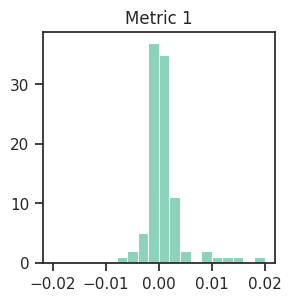

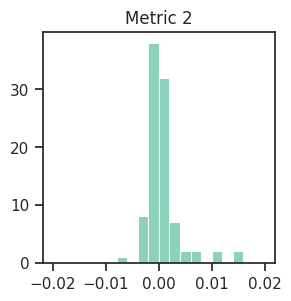

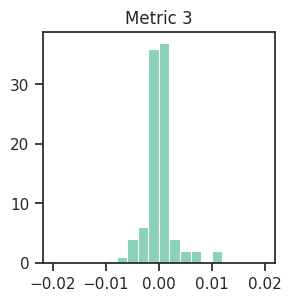

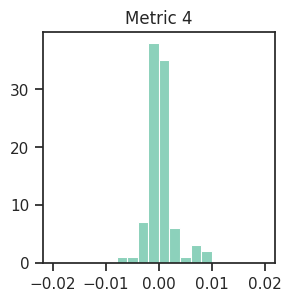

In [11]:
for metric_id in effect_size_df['metric_id'].unique():

    cohens_d_data = (
        effect_size_df[effect_size_df['metric_id'] == metric_id]['cohens_d'])

    print(f'Metric {metric_id} - Sample variance: {np.var(cohens_d_data)}')

    fig, ax = plt.subplots(figsize=(3, 3))
    sns.histplot(ax=ax,
                 data=cohens_d_data,
                 bins=np.linspace(-0.02,0.02,21))
    #axlabel='Metric: '+ str(metric_id)
#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 28)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(f"Metric {metric_id}")

    fig.savefig(figures_folder + 'cohens_d_metric_' + str(metric_id) + '.pdf',
                transparent=True,
                bbox_inches='tight')

## Distribution of effect size - Bayesian effect size

$$\frac{\bar{Y}_m - \bar{X}_n}{\sqrt{\big(\frac{\sigma^2_X}{n} + \frac{\sigma^2_Y}{m}\big) / \left(\frac{1}{n}+ \frac{1}{m}\right)}}$$

Metric 1 - Sample variance: 1.3020009248594856e-05
Metric 2 - Sample variance: 1.0661803999734502e-05
Metric 3 - Sample variance: 6.490907690571599e-06
Metric 4 - Sample variance: 5.931773520743275e-06


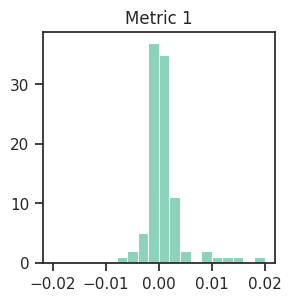

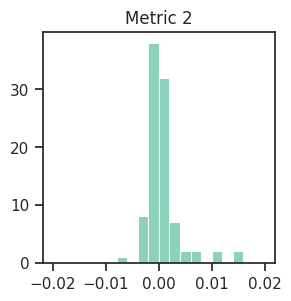

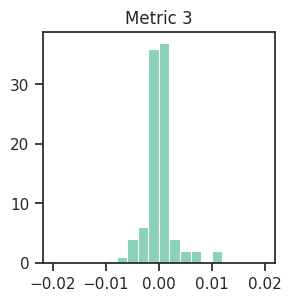

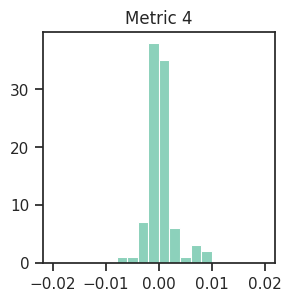

In [12]:
for metric_id in effect_size_df['metric_id'].unique():

    bayesian_effect_size_data = (
        effect_size_df[effect_size_df['metric_id'] == metric_id]
        ['bayesian_effect_size'])

    print(f'Metric {metric_id} - Sample variance: {np.var(bayesian_effect_size_data)}')

    fig, ax = plt.subplots(figsize=(3, 3))
    sns.histplot(ax=ax,
                 data=bayesian_effect_size_data,
                 bins=np.linspace(-0.02,0.02,21))
    #axlabel='Metric: '+ str(metric_id)
#     ax.set_xlim(0, 1)
#     ax.set_ylim(0, 28)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(f"Metric {metric_id}")

    fig.savefig(figures_folder + 'bayesian_effect_size_metric_' + str(metric_id) + '.pdf',
                transparent=True,
                bbox_inches='tight')

## Distribution of p-values under Welch's t-test

Code leading to Figure 1 in Page 8 of the paper.

In [13]:
t_test_data_df = (
  experiment_keys_overall_df
  .reset_index()
  .merge(abtest_metrics_df, how='inner')
)

In [14]:
ttest_lambda = (
    lambda x: scipy.stats.ttest_ind_from_stats(
        x['mean_c'],np.sqrt(x['variance_c']),
        x['count_c'], x['mean_t'],
        np.sqrt(x['variance_t']), x['count_t'],
        equal_var=False)[1])

In [15]:
t_test_data_df['t-test-p-value'] = (
    t_test_data_df.apply(ttest_lambda, axis=1))

abtest_metrics_df = (
    abtest_metrics_df.merge(
        t_test_data_df[['experiment_id', 'variant_id',
                        'metric_id','t-test-p-value']],
        on=['experiment_id', 'variant_id', 'metric_id'])
)

metric_id 1
metric_id 2
metric_id 3
metric_id 4


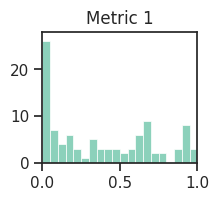

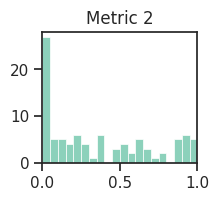

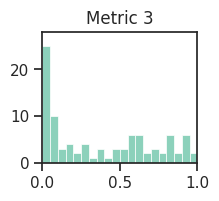

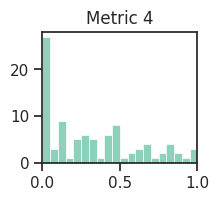

In [16]:
for metric_id in t_test_data_df['metric_id'].unique():
    print('metric_id', metric_id)

    fig, ax = plt.subplots(figsize=(2, 1.7))
    sns.histplot(ax=ax,
                data=t_test_data_df[t_test_data_df['metric_id'] == metric_id]
                                   ['t-test-p-value'],
                bins=np.linspace(0,1,21))
    #axlabel='Metric: '+ str(metric_id)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 28)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(f"Metric {metric_id}")

    fig.savefig(figures_folder + 't-test_p-value_metric_' + str(metric_id) + '.pdf',
                transparent=True,
                bbox_inches='tight')

## Change in mSPRT p-values / Bayesian posterior belief in null

Code leading to Figure 2 (Page 8).

In [17]:
# Calculate mSPRT p-value for ALL rows

# One tau_sq for each metric
# The naive tau_sq estimate is the sample variance
# of Cohen's d calculated above
# Metric 1 - Sample variance: 1.301572657324043e-05
# Metric 2 - Sample variance: 1.0651973563344495e-05
# Metric 3 - Sample variance: 6.478802824829137e-06
# Metric 4 - Sample variance: 5.915041799704489e-06
naive_tau_sq = {
    1: 1.30e-05,
    2: 1.07e-05,
    3: 6.48e-06,
    4: 5.92e-06,
}

abtest_metrics_df['mSPRT-vanilla-p-value-aux'] = (
  abtest_metrics_df.apply(
    lambda row: mSPRT_vanilla_normal_p_value_aux(
      mean_x=row['mean_c'], mean_y=row['mean_t'],
      variance_x=row['variance_c'], variance_y=row['variance_t'],
      count_x=row['count_c'], count_y=row['count_t'],
      theta_0=0, tau_sq=naive_tau_sq[row['metric_id']] * row['variance_c']),
    axis=1)
)

In [18]:
abtest_metrics_df = (
    abtest_metrics_df.sort_values(
        ['experiment_id', 'variant_id', 'metric_id']))

# Apply the streming definition of a mSPRT p-value
abtest_metrics_df['mSPRT-vanilla-p-value'] = (
  abtest_metrics_df
  .groupby(['experiment_id', 'variant_id', 'metric_id'])
  ['mSPRT-vanilla-p-value-aux']
  .transform(lambda row: row.expanding(min_periods=2).min())
)

abtest_metrics_df['mSPRT-vanilla-p-value'] = (
  abtest_metrics_df['mSPRT-vanilla-p-value'].fillna(1.0)
)

In [19]:
# Calculate Bayesian A/B test Bayes Factor +
# Posterior null probability (P(H_0 is true | observation)) for ALL rows

# One V_sq estimate for each metric
# The naive V_sq estimate takes the sample variance of
# Bayesian effect size calculated above
# Metric 1 - Sample variance: 1.3020009248594856e-05
# Metric 2 - Sample variance: 1.0661803999734505e-05
# Metric 3 - Sample variance: 6.490907690571599e-06
# Metric 4 - Sample variance: 5.931773520743273e-06
naive_V_sq = {
    1: 1.30e-05,
    2: 1.07e-05,
    3: 6.49e-06,
    4: 5.93e-06,
}

abtest_metrics_df['bayesian_posterior_H0_probability'] = (
    abtest_metrics_df.apply(
        lambda row: bayesian_posterior_H0_probability(
          mean_x=row['mean_c'], mean_y=row['mean_t'],
          variance_x=row['variance_c'], variance_y=row['variance_t'],
          count_x=row['count_c'], count_y=row['count_t'],
          theta_0=0, V_sq=naive_V_sq[row['metric_id']],
          prior_H0_probability=0.75),
        axis=1)
)

In [20]:
abtest_metrics_df = (
    abtest_metrics_df.merge(
        abtest_metrics_df
            .groupby(['experiment_id', 'variant_id', 'metric_id'])['time_since_start']
            .max()
            .reset_index()
            .rename(columns={'time_since_start':'design_duration'}),
        on=['experiment_id', 'variant_id', 'metric_id'])
)

# Calculate % experiemnt progress (i.e. time_since_start / max(time_since_start))
abtest_metrics_df['time_progress'] = (
    abtest_metrics_df['time_since_start'] /
    abtest_metrics_df['design_duration'])

abtest_metrics_df['experiment_variant_id'] = (
    abtest_metrics_df['experiment_id'].map(str) + '-' +
    abtest_metrics_df['variant_id'].map(str))

In [21]:
abtest_metrics_df

,experiment_id,variant_id,metric_id,time_since_start,count_c,count_t,mean_c,mean_t,variance_c,variance_t,t-test-p-value,mSPRT-vanilla-p-value-aux,mSPRT-vanilla-p-value,bayesian_posterior_H0_probability,design_duration,time_progress,experiment_variant_id
0,036afc,2,1,1.5,188065.0,186686.0,0.107808,0.107828,0.096186,0.096201,4.558169e-01,1.000000e+00,1.000000e+00,8.170960e-01,76.5,0.019608,036afc-2
1,036afc,2,1,2.0,245041.0,243694.0,0.131790,0.131435,0.114422,0.114160,4.558169e-01,1.000000e+00,1.000000e+00,8.224186e-01,76.5,0.026144,036afc-2
2,036afc,2,1,2.5,277237.0,275949.0,0.143065,0.142711,0.122598,0.122345,4.558169e-01,1.000000e+00,1.000000e+00,8.274310e-01,76.5,0.032680,036afc-2
3,036afc,2,1,3.0,315689.0,314676.0,0.161789,0.160997,0.135613,0.135077,4.558169e-01,1.000000e+00,1.000000e+00,8.038914e-01,76.5,0.039216,036afc-2
4,036afc,2,1,3.5,338631.0,337715.0,0.172474,0.171067,0.142727,0.141803,4.558169e-01,7.973255e-01,7.973255e-01,7.051244e-01,76.5,0.045752,036afc-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24148,fdaf62,1,4,28.0,2182559.0,2180705.0,38.270483,38.858464,8478.894092,8708.839083,5.541495e-12,1.576039e-08,1.576039e-08,4.578688e-08,32.0,0.875000,fdaf62-1
24149,fdaf62,1,4,29.0,2259937.0,2257899.0,38.485748,39.065107,8627.264583,8821.982824,5.541495e-12,1.756702e-08,1.576039e-08,5.134087e-08,32.0,0.906250,fdaf62-1
24150,fdaf62,1,4,30.0,2341537.0,2339309.0,38.691410,39.211843,8916.435308,8848.559719,5.541495e-12,4.742553e-07,1.576039e-08,1.427344e-06,32.0,0.937500,fdaf62-1
24151,fdaf62,1,4,31.0,2422152.0,2419745.0,38.705264,39.263485,8836.078773,8884.955277,5.541495e-12,2.219117e-08,1.576039e-08,6.602956e-08,32.0,0.968750,fdaf62-1


In [23]:
test_df=abtest_metrics_df.loc[(abtest_metrics_df['experiment_id']=="2c8a04") &\
                              (abtest_metrics_df['variant_id']==1) &\
                              (abtest_metrics_df['metric_id']==2)
                              ]

In [ ]:
from scipy.special import loggamma, gammaln, xlogy
import numpy as np

def sequential_p_value(counts, assignment_probabilities, dirichlet_alpha=None):
    """
    Compute the sequential p-value for given counts and assignment probabilities.
    Lindon, Michael, and Alan Malek.
    "Anytime-Valid Inference For Multinomial Count Data."
    In Advances in Neural Information Processing Systems, 2022
    https://openreview.net/pdf?id=a4zg0jiuVi
    Parameters
    ----------
    counts : array like
        The observed counts in each treatment group.
    assignment_probabilities : array like
        The assignment probabilities to each treatment group.
    dirichlet_alpha : array like, optional
        The Dirichlet mixture parameter.
    Returns
    -------
    float
        The sequential p-value.
    """
    counts = np.array(counts)
    assignment_probabilities = np.array(assignment_probabilities)
    if dirichlet_alpha is None:
        dirichlet_alpha = 100 * assignment_probabilities
    else:
        dirichlet_alpha = np.array(dirichlet_alpha)
    lm1 = (
        loggamma(counts.sum() + 1)
        - loggamma(counts + 1).sum()
        + loggamma(dirichlet_alpha.sum())
        - loggamma(dirichlet_alpha).sum()
        + loggamma(dirichlet_alpha + counts).sum()
        - loggamma((dirichlet_alpha + counts).sum())
    )
    lm0 = gammaln(counts.sum() + 1) + np.sum(
        xlogy(counts, assignment_probabilities) - gammaln(counts + 1), axis=-1
    )
    return min(1, np.exp(lm0 - lm1))

In [ ]:
def net_p(c,t):
  counts = [c, t]
  assignment_probabilities = [0.5, 0.5]
  return sequential_p_value(counts, assignment_probabilities)

In [28]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, 2598 to 2843
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   experiment_id                      246 non-null    object 
 1   variant_id                         246 non-null    int64  
 2   metric_id                          246 non-null    int64  
 3   time_since_start                   246 non-null    float64
 4   count_c                            246 non-null    float64
 5   count_t                            246 non-null    float64
 6   mean_c                             246 non-null    float64
 7   mean_t                             246 non-null    float64
 8   variance_c                         246 non-null    float64
 9   variance_t                         246 non-null    float64
 10  t-test-p-value                     246 non-null    float64
 11  mSPRT-vanilla-p-value-aux          246 non-null    float64


In [29]:
test_df['c_sum']=test_df.map(lambda row: row['count_c'] * row['mean_c'])
test_df["t_sum"]=test_df.map(lambda row: row["count_t"] * row["mean_t"])


TypeError: string indices must be integers

In [ ]:
target_experiment_variant_id = [
    'c56288-1', 'a4386f-1', 'bac0d3-1', '08bcc2-1', '591c2c-1'
]

In [ ]:
for metric_id in abtest_metrics_df['metric_id'].unique():

    fig, ax = plt.subplots(figsize=(3, 1.8))

    sns.lineplot(x="time_progress", y="mSPRT-vanilla-p-value",
                 hue="experiment_variant_id",
                 data=abtest_metrics_df[
                     (abtest_metrics_df.experiment_variant_id.isin(
                         target_experiment_variant_id)) &
                     (abtest_metrics_df.metric_id==metric_id)],
                 ax=ax,
                 legend=None)

    ax.set_xlim(0, 1)
    ax.set_ylim(-0.02, 1.02)

    ax.set_ylabel('mSPRT $p$-value')
    ax.set_xlabel(None)

    fig.savefig(figures_folder + 'time_progress_mSPRT_metric_' + str(metric_id) + '.pdf',
                bbox_inches='tight')

In [ ]:
for metric_id in abtest_metrics_df['metric_id'].unique():
    fig, ax = plt.subplots(figsize=(3, 1.8))

    sns.lineplot(x="time_progress", y="bayesian_posterior_H0_probability",
                 hue="experiment_variant_id",
                 data=abtest_metrics_df[
                     (abtest_metrics_df.experiment_variant_id.isin(
                         target_experiment_variant_id)) &
                     (abtest_metrics_df.metric_id==metric_id)],
                 ax=ax)

    ax.set_xlim(0, 1)
    ax.set_ylim(-0.02, 1.02)

    ax.set_ylabel('$P(H_0 | Data)$')
    ax.set_xlabel(None)

    ax.legend(title='Expt.-Variant ID',
              loc='upper left',
              bbox_to_anchor=(1, 1))

    fig.savefig(figures_folder + 'time_progress_bayesian_metric_' +
                str(metric_id) + '.pdf',
                bbox_inches='tight')

# Comparison between Welch's t-test and mSPRT

"Confusion matrices" between Welch's t-test and mSPRT at the end of eperiment - Table 2 (Page 10).

In [ ]:
abtest_metrics_df['Both significant'] = (
    (abtest_metrics_df['t-test-p-value']<=alpha) &
    (abtest_metrics_df['mSPRT-vanilla-p-value']<=alpha))
abtest_metrics_df['Only mSPRT significant'] = (
    (abtest_metrics_df['t-test-p-value']>alpha) &
    (abtest_metrics_df['mSPRT-vanilla-p-value']<=alpha))
abtest_metrics_df['Both not significant'] = (
    (abtest_metrics_df['t-test-p-value']>alpha) &
    (abtest_metrics_df['mSPRT-vanilla-p-value']>alpha))
abtest_metrics_df['Only t-test significant'] = (
    (abtest_metrics_df['t-test-p-value']<=alpha) &
    (abtest_metrics_df['mSPRT-vanilla-p-value']>alpha))

In [ ]:
(abtest_metrics_df
 [(abtest_metrics_df['time_progress']==1)]
 .groupby('metric_id')
 [['Both significant','Only mSPRT significant',
   'Both not significant','Only t-test significant']]
 .sum()
)

In [ ]:
nbins = 10
labels=['Both not significant','Only mSPRT significant',
        'Only t-test significant','Both significant']
abtest_metrics_df['time_progress_bin'] = (
    pd.cut(abtest_metrics_df['time_progress'],
           np.linspace(0,1,nbins+1), retbins=False))

#count snapshots per time_bin
abtest_metrics_evol_df = (
    abtest_metrics_df
        .groupby(['experiment_variant_id','time_progress_bin'])[['time_progress']]
        .count().groupby('experiment_variant_id').min()
        .rename(columns={'time_progress':'min_samples_in_time_bin'})
        .reset_index()
)

#filter experiment_variant_id that have at least one entry per time bin
abtest_metrics_evol_df = (
    abtest_metrics_evol_df
        [abtest_metrics_evol_df['min_samples_in_time_bin']>=1]
        [['experiment_variant_id']])

print('# experiments with at least one entry per time bin',
      len(abtest_metrics_evol_df['experiment_variant_id'].unique()))

abtest_metric_evol_df = (
    abtest_metrics_df[['experiment_variant_id','metric_id','time_progress_bin'] + labels]
        .merge(abtest_metrics_evol_df,
               on='experiment_variant_id')
        .groupby(['time_progress_bin', 'experiment_variant_id', 'metric_id']).last()
        .reset_index())

abtest_metric_evol_df['time_progress_bin'] = (
    [x.right for x in abtest_metric_evol_df['time_progress_bin'].values])

abtest_metric_evol_df = (
    abtest_metric_evol_df.groupby(['time_progress_bin','metric_id'])
    .mean().reset_index())


In [ ]:
abtest_metric_evol_df

In [ ]:
for metric_id in abtest_metric_evol_df['metric_id'].unique():
    print('metric_id', metric_id)
    x = abtest_metric_evol_df['time_progress_bin'].unique()
    y = abtest_metric_evol_df[abtest_metric_evol_df['metric_id'] == metric_id][labels].T.values

    # set seaborn style

    # Plot
    plt.stackplot(x,y, labels=labels)
    plt.ylim(0,1)
    plt.xlim(0.1, 1)

    plt.legend(loc='lower center')
    plt.show()
    plt.savefig(figures_folder + 'time_progress_type_metric_' + str(metric_id) + '.pdf')


Future work:

* Confusion matrix between Welch's t-test and Bayesian A/B test
* Cumulative plot off type-I, type-II and correct rejection or no-rejection
* Show data spike experiment, comment on how it affects mSPRT(vanilla), mSPRT(in deployment) and Bayesian A/B Test.
